In [2]:
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random

from a_api import TextMetrics, load_ngrams
from plot import plot_dict, plot_dict_bars, matrix_plot
from util import dictcount

grand_t0 = dt.datetime.now()

# Create Datasets
## Merge original binary and multiclass datasets into one

In [3]:
# Dataset: Multiple Distorions (sagarikashreevastava)
# Paper: https://aclanthology.org/2021.clpsych-1.17/
# Data: https://www.kaggle.com/datasets/sagarikashreevastava/cognitive-distortion-detetction-dataset

binary_dataset_file_path = "../../data/corpora/English/distortions/halilbabacan/raw_Cognitive_distortions.csv" 

import kagglehub
multiclass_dataset_path = kagglehub.dataset_download("sagarikashreevastava/cognitive-distortion-detetction-dataset")
multiclass_dataset_file_path = multiclass_dataset_path + "/Annotated_data.csv"

df1 = pd.read_csv(binary_dataset_file_path)
df1 = df1.rename(columns={'Text': 'Patient Question', 'Label': 'Dominant Distortion'})
df1.insert(1, "Distorted part", value = np.nan)
df1.insert(3, "Secondary Distortion (Optional)", value = np.nan)

df2 = pd.read_csv(multiclass_dataset_file_path) 
df2 = df2.drop('Id_Number', axis=1) # delete columnb with id 

df3 = pd.concat([df1, df2], ignore_index=True)
# df3 = pd.concat([df3.iloc[:100], df3.iloc[-100:]], ignore_index=True) # hack for test
df3

,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,I'm such a failure I never do anything right.,NaN,Distortion,NaN
1,Nobody likes me because I'm not interesting.,NaN,Distortion,NaN
2,I can't try new things because I'll just mess...,NaN,Distortion,NaN
3,My boss didn't say 'good morning' she must be...,NaN,Distortion,NaN
4,My friend didn't invite me to the party I mus...,NaN,Distortion,NaN
...,...,...,...,...
6052,I’m a 21 year old female. I spent most of my l...,NaN,No Distortion,NaN
6053,I am 21 female and have not had any friends fo...,Now I am at university my peers around me all ...,Overgeneralization,NaN
6054,From the U.S.: My brother is 19 years old and ...,He claims he’s severely depressed and has outb...,Mental filter,Mind Reading
6055,From the U.S.: I am a 21 year old woman who ha...,NaN,No Distortion,NaN


In [4]:
l_no_distorted = len(df3[df3['Dominant Distortion']=='No Distortion'])
l_distorted = len(df3[df3['Dominant Distortion']!='No Distortion'])
print(len(df3),l_distorted,l_no_distorted,round(float(l_distorted)/len(df3),2),round(float(l_no_distorted)/len(df3),2))

6057 4191 1866 0.69 0.31


## Create 3 split datasets for evaluation
### Check the label probaility distributions 

In [5]:
print('Full set',len(df3))
df_test = df3[df3.index % 10 == 0]
print('Test set',len(df_test))
df_test = df_test.reset_index(drop=True)
df_test

Full set 2530
Test set 253


,Patient Question,Distorted part,Dominant Distortion,Secondary Distortion (Optional)
0,"Hello, I have a beautiful,smart,outgoing and a...",The voice are always fimilar (someone she know...,Personalization,NaN
1,My husband and I have been married for over a ...,"I thought that he displayed traits of honor, l...",Labeling,NaN
2,I have always suffered from performance anxiet...,During this time I was recruited to many great...,Fortune-telling,NaN
3,"As I’ve been becoming older, I’ve been getting...",But sometimes I can’t help what I say to my pa...,Emotional Reasoning,All-or-nothing thinking
4,I have been married for 15 years. I have grown...,I have grown very much but he has not. He will...,Labeling,Overgeneralization
...,...,...,...,...
248,From 15-year-old girl in Canada: Recently I fe...,Recently I felt like my parents really hate me.,Mind Reading,NaN
249,I used to get many strange looks for the thing...,NaN,No Distortion,NaN
250,I can remember at least 3 incidents as a child...,NaN,No Distortion,NaN
251,From the U.S.: I’ve been diagnosed with OCD si...,"Lately, I’ve been feeling like someone is watc...",Emotional Reasoning,NaN


In [6]:
df_tests= [
    df_test[df_test.index % 3 == 1],
    df_test[df_test.index % 3 == 2],
    df_test[df_test.index % 3 == 0],
]
for df in df_tests + [df_test,df3]:
    l_no_distorted = len(df[df['Dominant Distortion']=='No Distortion'])
    l_distorted = len(df[df['Dominant Distortion']!='No Distortion'])
    print(len(df),l_distorted,l_no_distorted,round(float(l_distorted)/len(df),2),round(float(l_no_distorted)/len(df),2))


84 58 26 0.69 0.31
84 62 22 0.74 0.26
85 47 38 0.55 0.45
253 167 86 0.66 0.34
2530 1597 933 0.63 0.37


# Create Evaluation Functions

In [7]:
def language_metrics(lang,metrics_list,path):
    metrics = {}
    for m in metrics_list:
        metrics[m] = path + lang + '/' + m + '.txt'
    return metrics

def our_evaluator_tm_any(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    for m in metrics:
        if metrics[m] > threshold:
            return True
    return False

def our_evaluator_tm_avg(tm,text,threshold):
    metrics = tm.get_sentiment_words(text)
    l = list(metrics.values())
    avg = sum(l) / len(l) if  len(l) > 0 else 0
    if avg > threshold:
        return True
    return False

def our_evaluator_tm_true(tm,text,threshold):
    return True
    
def our_evaluator_tm_false(tm,text,threshold):
    return False

def our_evaluator_tm_random(tm,text,threshold):
    return random.choice([True, False])

def f1_from_counts(true_positive, true_negative, false_positive, false_negative):
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    return 2 * precision * recall / (precision + recall) if precision > 0 or recall > 0 else 0 

def evaluate_tm_df_counts(df,tm,evaluator,threshold,debug=False):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    for _, row in df.iterrows():
        # Text definition: first, check the 2nd column; if NaN, take the text from the 1st column.
        text = row.iloc[1] if pd.notna(row.iloc[1]) else row.iloc[0]
        primary_distortion = row.iloc[2]  # The main cognitive distortion from the 3rd column
        secondary_distortion = row.iloc[3] if pd.notna(row.iloc[3]) else None  # The secondary distortion from the 4th column, if it exists
        ground_distortion = False if primary_distortion == 'No Distortion' else True
                       
        our_distortion = evaluator(tm,text,threshold)
        
        # https://en.wikipedia.org/wiki/F-score
        if ground_distortion == True and our_distortion == True:
            true_positive += 1
        if ground_distortion == False and our_distortion == True:
            false_positive += 1
        if ground_distortion == False and our_distortion == False:
            true_negative += 1
        if ground_distortion == True and our_distortion == False:
            false_negative += 1

        if debug:
            print(ground_distortion,our_distortion,primary_distortion,secondary_distortion,text[:20])

    return true_positive, true_negative, false_positive, false_negative

def evaluate_tm_df(df,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_df_counts(df,tm,evaluator,threshold,debug)
    return f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def evaluate_tm_df_acc_f1(df,tm,evaluator,threshold,debug=False):
    true_positive, true_negative, false_positive, false_negative = evaluate_tm_df_counts(df,tm,evaluator,threshold,debug)
    return (true_positive + true_negative) / len(df), f1_from_counts(true_positive, true_negative, false_positive, false_negative) 

def agg_min_max_avg_mpe(runs):
    max_v = max(runs)
    min_v = min(runs)
    avg_v = sum(runs)/len(runs)
    # https://en.wikipedia.org/wiki/Mean_absolute_error
    mpe_v = sum([abs(v-avg_v) for v in runs])/len(runs)/avg_v*100 if avg_v > 0 else 0
    return min_v, max_v, avg_v, mpe_v


# Evaluate Different Models
## Evaluate All "Ours" Models without of Splits


In [8]:
models = {}

models['Ours base (binary), log'] = TextMetrics(language_metrics('',['distortions-only'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

# + emotions
models['Ours base+ (binary), log'] = TextMetrics(language_metrics('',['distortions-all-emotions'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

#models['Ours base with negative emotions (binary), log'] = TextMetrics(language_metrics('',['distortions-negative-emotions'],
#                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

models['Ours base+ (multi-class), log'] = TextMetrics(language_metrics('',['positive','negative','rude',
                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
                                            'overgeneralizing','personalizing','should-statement'],
                                            path='../../data/models/distortions/ours/'),metric_logarithmic=True,debug=False)

#models['Ours base+ (multi-class), no log'] = TextMetrics(language_metrics('',['positive','negative','rude',
#                                            'catastrophizing','dichotomous-reasoning','disqualifying-positive','emotional-reasoning',
#                                            'fortune-telling','labeling','magnification','mental-filtering','mindreading',
#                                            'overgeneralizing','personalizing','should-statement'],
#                                            path='../../data/models/distortions/ours/'),metric_logarithmic=False,debug=False)

models['Ours new (binary), log'] = TextMetrics(language_metrics('',['Distortion'],
                                            path='../../data/models/distortions/shreevastava_2021_binary/first_split'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

#models['Ours new (binary), no log'] = TextMetrics(language_metrics('',['Distortion'],
#                                            path='../../data/models/distortions/shreevastava_2021_binary/first_split'),
#                                            encoding="utf-8",metric_logarithmic=False,debug=False)

models['Ours new (multi-class), log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/shreevastava_2021_multiclass/first_split'),
                                            encoding="utf-8",metric_logarithmic=True,debug=False)

models['Ours new (multi-class), no log'] = TextMetrics(language_metrics('',['All-or-nothing_thinking','Fortune-telling','Mental_filter','Overgeneralization','Distortion',
                                                'Labeling','Mind_Reading','Personalization','Emotional_Reasoning','Magnification',
                                                'Should_statements'],
                                            path='../../data/models/distortions/shreevastava_2021_multiclass/first_split'),
                                            encoding="utf-8",metric_logarithmic=False,debug=False)


In [9]:
def matrix_plot(row_labels, col_labels, matrix, absmax, title = None, vmin = None, vmax = None, dpi = None, titlefontsize = None, width = 20):
    plt.rcParams["figure.figsize"] = (width,len(row_labels)/4)
    if not dpi is None:
        plt.rcParams["figure.dpi"] = dpi
    p = sns.heatmap(matrix, xticklabels=col_labels, yticklabels=row_labels, 
                    vmin = -absmax if vmin is None else vmin, 
                    vmax = absmax if vmax is None else vmax, 
                    cmap='RdYlGn', annot=True)
    if title is not None:
        if titlefontsize is None:
            titlefontsize = 32 if len(title) < 50 else round(32 * 50 / len(title))
        p.set_title(title,fontsize = titlefontsize)
    plt.show()

def test_evaluate_df(df_eval):
    thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    models_results = {}
    models_acc = []
    models_f1 = []
    
    for model in [m for m in models]:
        for evaluator in [our_evaluator_tm_any,our_evaluator_tm_avg] if 'multi-class' in model else [our_evaluator_tm_any]:
            evalname = 'any' if evaluator == our_evaluator_tm_any else 'avg' 
            print(f'{model}, {evalname}')
            best_t = 0
            best_acc = 0
            best_f1 = 0
            res_acc = {}
            res_f1 = {}
            for t in thresholds:
                acc, f1 = evaluate_tm_df_acc_f1(df_eval,models[model],evaluator,t,debug=False)
                if acc > best_acc:
                    best_t = t
                    best_acc = acc
                    best_f1 = f1
                res_acc[t] = acc
                res_f1[t] = f1
                print(model, t, acc, f1)
            models_acc.append([round(res_acc[t],2) for t in thresholds])
            models_f1.append([round(res_f1[t],2) for t in thresholds])
            t0 = dt.datetime.now()
            acc, f1 = evaluate_tm_df_acc_f1(df_eval,models[model],our_evaluator_tm_any,best_t,debug=False)
            t1 = dt.datetime.now()
            delta = t1 - t0
            print(model, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
            models_results[f'{model}, {evalname}'] = ( models[model], evalname, best_t, best_acc, best_f1, delta.total_seconds(), delta.total_seconds()/len(df3) )
    assert len([r for r in models_results]) == len(models_acc)
    
    print()
    for result in models_results:
        print(models_results[result],model)

    print()
    for i in range(len(models_results)):
        model = [m for m in models_results][i]
        row = models_acc[i]
        maxt = 0
        maxacc = 0
        for col in range(len(row)):
            if row[col] > maxacc:
                maxacc = row[col]
                maxt = thresholds[col]
        if maxacc >= 0.8:
            print(maxacc,maxt,model)

    return thresholds, models_results, models_acc, models_f1

In [10]:
thresholds, models_results, models_acc, models_f1 = test_evaluate_df(df_test)

Ours base (binary), log, any
Ours base (binary), log 0.1 0.4189723320158103 0.5476923076923077
Ours base (binary), log 0.2 0.4743083003952569 0.5667752442996743
Ours base (binary), log 0.3 0.5217391304347826 0.5433962264150943
Ours base (binary), log 0.4 0.4980237154150198 0.4253393665158371
Ours base (binary), log 0.5 0.4308300395256917 0.2421052631578947
Ours base (binary), log 0.6 0.35177865612648224 0.03529411764705882
Ours base (binary), log 0.7 0.33992094861660077 0
Ours base (binary), log 0.8 0.33992094861660077 0
Ours base (binary), log 0.9 0.33992094861660077 0
Ours base (binary), log 0.3 0.5217391304347826 0.5433962264150943 0.098786 3.904584980237154e-05
Ours base+ (binary), log, any
Ours base+ (binary), log 0.1 0.6521739130434783 0.7894736842105262
Ours base+ (binary), log 0.2 0.6521739130434783 0.7894736842105262
Ours base+ (binary), log 0.3 0.6482213438735178 0.7865707434052759
Ours base+ (binary), log 0.4 0.6403162055335968 0.7796610169491526
Ours base+ (binary), log 0.5

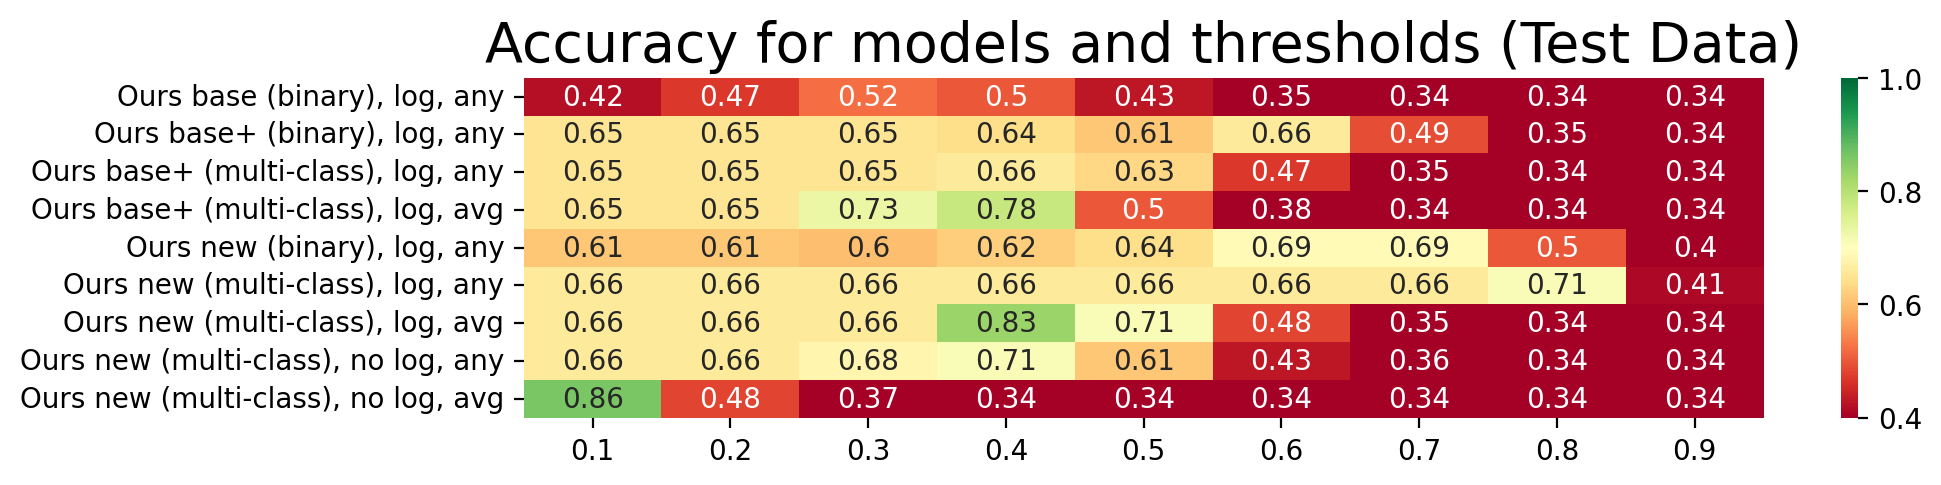

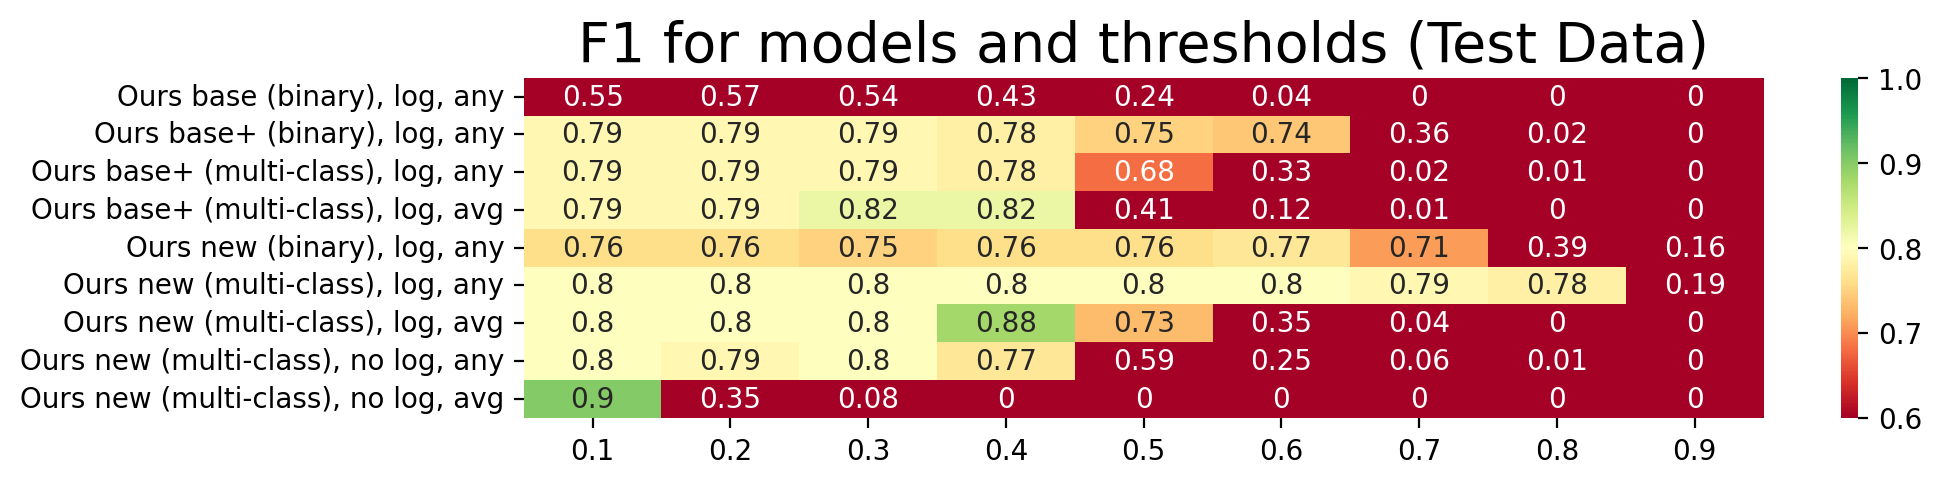

In [11]:
matrix_plot([m for m in models_results], thresholds, models_acc, 1.0, title = f'Accuracy for models and thresholds (Test Data)', 
            vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

matrix_plot([m for m in models_results], thresholds, models_f1, 1.0, title = f'F1 for models and thresholds (Test Data)', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

In [12]:
thresholds, models_results_a, models_acc_a, models_f1_a = test_evaluate_df(df3)


Ours base (binary), log, any
Ours base (binary), log 0.1 0.4553359683794466 0.5744286596664607
Ours base (binary), log 0.2 0.5110671936758894 0.5918838667106566
Ours base (binary), log 0.3 0.5458498023715415 0.5592635212888378
Ours base (binary), log 0.4 0.5264822134387351 0.44123134328358204
Ours base (binary), log 0.5 0.45296442687747035 0.2445414847161572
Ours base (binary), log 0.6 0.3968379446640316 0.08513189448441247
Ours base (binary), log 0.7 0.3731225296442688 0.013681592039800995
Ours base (binary), log 0.8 0.36877470355731223 0
Ours base (binary), log 0.9 0.36877470355731223 0
Ours base (binary), log 0.3 0.5458498023715415 0.5592635212888378 0.981651 0.00038800434782608695
Ours base+ (binary), log, any
Ours base+ (binary), log 0.1 0.6245059288537549 0.7688564476885645
Ours base+ (binary), log 0.2 0.6245059288537549 0.7688564476885645
Ours base+ (binary), log 0.3 0.6245059288537549 0.7686312713102778
Ours base+ (binary), log 0.4 0.6197628458498023 0.7639842983316978
Ours bas

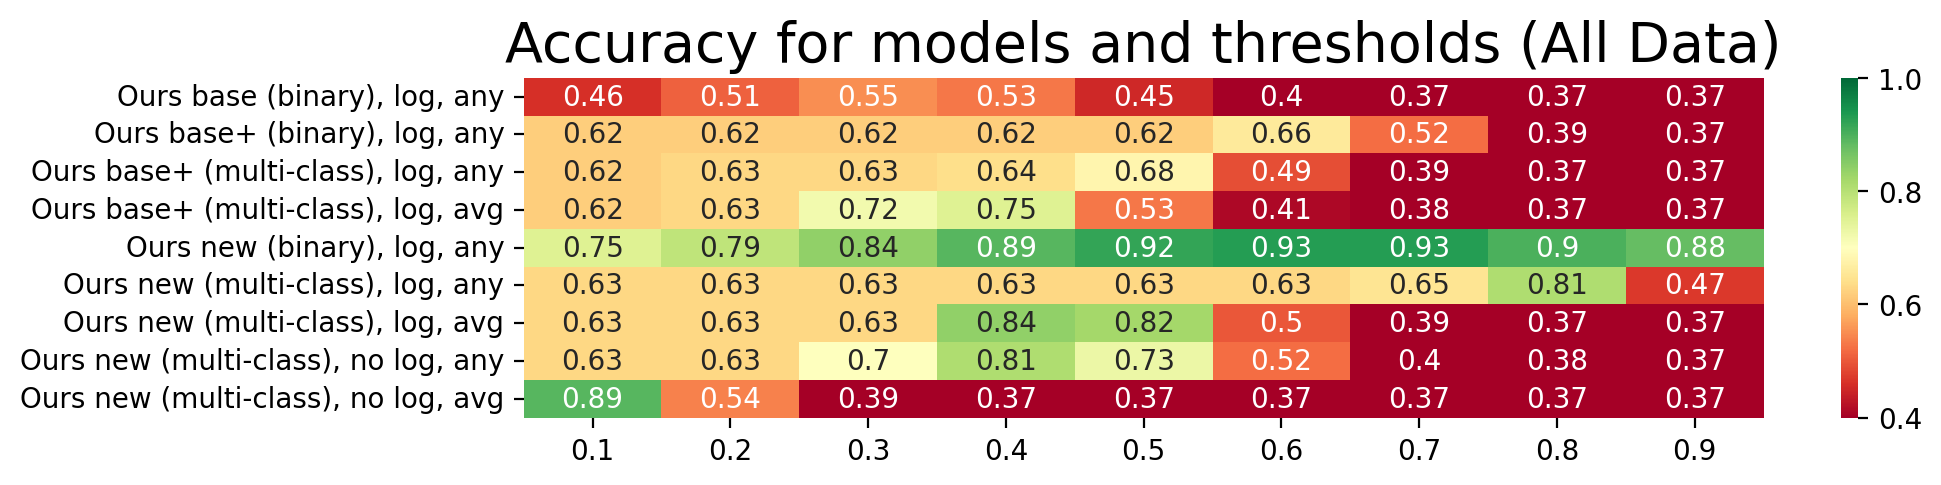

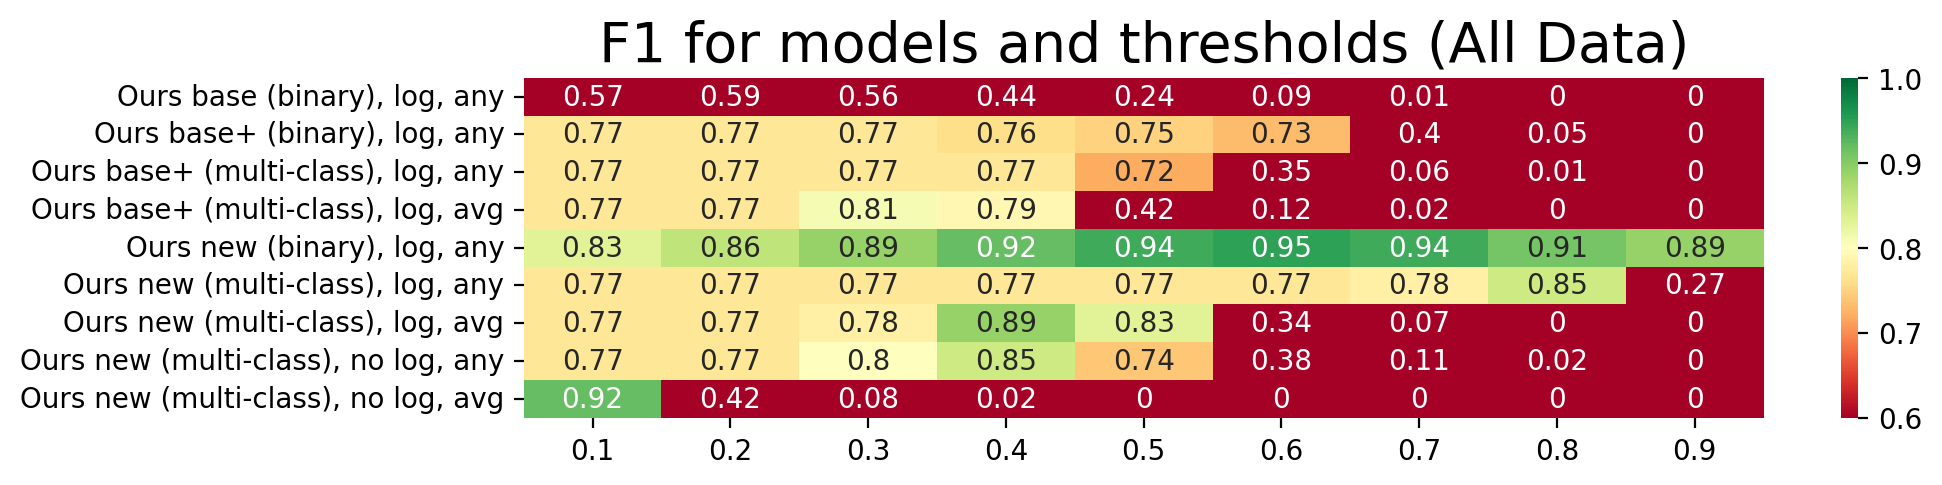

In [13]:
matrix_plot([m for m in models_results_a], thresholds, models_acc_a, 1.0, title = f'Accuracy for models and thresholds (All Data)', 
            vmin = 1.0-(1.0-0.7)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

matrix_plot([m for m in models_results_a], thresholds, models_f1_a, 1.0, title = f'F1 for models and thresholds (All Data)', 
            vmin = 1.0-(1.0-0.8)*2, vmax = 1.0, titlefontsize = 20, dpi = 200, width = 10)

## Evaluate All "Ours New" Models on Splits to get "error bars"

In [14]:
results = {}

#add baseline evaluations

baselines = {
    "Const(True)": our_evaluator_tm_true,
    #"Const(False)": our_evaluator_tm_false,
    #"Random": our_evaluator_tm_random
}

for baseline in baselines:
    model_t = baseline
    t0 = dt.datetime.now()
    result = []
    lens = 0
    for df in df_tests:
        lens += len(df)  
        acc, f1 = evaluate_tm_df_acc_f1(df,None,baselines[baseline],0,debug=False)
        result.append((acc, f1))
    t1 = dt.datetime.now()
    delta = t1 - t0
    print(model_t,(result,delta.total_seconds(),delta.total_seconds()/len(df3)))
    results[model_t] = (result,delta.total_seconds(),delta.total_seconds()/len(df3))

results

Const(True) ([(0.6904761904761905, 0.8169014084507042), (0.7380952380952381, 0.8493150684931507), (0.5529411764705883, 0.7121212121212122)], 0.017425, 6.887351778656127e-06)


{'Const(True)': ([(0.6904761904761905, 0.8169014084507042),
   (0.7380952380952381, 0.8493150684931507),
   (0.5529411764705883, 0.7121212121212122)],
  0.017425,
  6.887351778656127e-06)}

In [15]:
for m in models_results:
    model, evalname, best_t, best_acc, best_f1, seconds, seconds_per_item = models_results[m]
    model_t = f"{m} ({best_t})"
    t0 = dt.datetime.now()
    result = []
    lens = 0
    for df in df_tests:
        lens += len(df)
        evaluator = our_evaluator_tm_any if evalname == 'any' else our_evaluator_tm_avg
        acc, f1 = evaluate_tm_df_acc_f1(df,model,evaluator,best_t,debug=False)
        result.append((acc, f1))
    t1 = dt.datetime.now()
    delta = t1 - t0
    print(model_t,(result,delta.total_seconds(),delta.total_seconds()/len(df3)))
    results[model_t] = (result,delta.total_seconds(),delta.total_seconds()/len(df3))

Ours base (binary), log, any (0.3) ([(0.5, 0.5531914893617021), (0.5119047619047619, 0.5393258426966292), (0.5529411764705883, 0.5365853658536586)], 0.117115, 4.629051383399209e-05)
Ours base+ (binary), log, any (0.6) ([(0.7142857142857143, 0.7999999999999999), (0.6071428571428571, 0.6972477064220183), (0.6470588235294118, 0.7)], 0.109906, 4.344110671936759e-05)
Ours base+ (multi-class), log, any (0.4) ([(0.7261904761904762, 0.8321167883211679), (0.7619047619047619, 0.8507462686567164), (0.5058823529411764, 0.6499999999999999)], 0.237035, 9.36897233201581e-05)
Ours base+ (multi-class), log, avg (0.4) ([(0.8214285714285714, 0.8648648648648648), (0.75, 0.8108108108108109), (0.7647058823529411, 0.7674418604651163)], 0.221831, 8.76802371541502e-05)
Ours new (binary), log, any (0.6) ([(0.6428571428571429, 0.7457627118644068), (0.75, 0.823529411764706), (0.6705882352941176, 0.7254901960784313)], 0.090745, 3.5867588932806325e-05)
Ours new (multi-class), log, any (0.8) ([(0.7142857142857143, 0

In [16]:
#TODO add ours with "optimized" hyperparameters


In [17]:
results

{'Const(True)': ([(0.6904761904761905, 0.8169014084507042),
   (0.7380952380952381, 0.8493150684931507),
   (0.5529411764705883, 0.7121212121212122)],
  0.017425,
  6.887351778656127e-06),
 'Ours base (binary), log, any (0.3)': ([(0.5, 0.5531914893617021),
   (0.5119047619047619, 0.5393258426966292),
   (0.5529411764705883, 0.5365853658536586)],
  0.117115,
  4.629051383399209e-05),
 'Ours base+ (binary), log, any (0.6)': ([(0.7142857142857143,
    0.7999999999999999),
   (0.6071428571428571, 0.6972477064220183),
   (0.6470588235294118, 0.7)],
  0.109906,
  4.344110671936759e-05),
 'Ours base+ (multi-class), log, any (0.4)': ([(0.7261904761904762,
    0.8321167883211679),
   (0.7619047619047619, 0.8507462686567164),
   (0.5058823529411764, 0.6499999999999999)],
  0.237035,
  9.36897233201581e-05),
 'Ours base+ (multi-class), log, avg (0.4)': ([(0.8214285714285714,
    0.8648648648648648),
   (0.75, 0.8108108108108109),
   (0.7647058823529411, 0.7674418604651163)],
  0.221831,
  8.76802

In [18]:
# Add LLM results
# read results from pickle file saved by "comparing_llms.ipynb" notebook
file = open('llm_evaluation_results', 'rb')
llm_results = pickle.load(file)
file.close()
#llm_results

for lr in llm_results:
    results[lr] = llm_results[lr]
results

{'Const(True)': ([(0.6904761904761905, 0.8169014084507042),
   (0.7380952380952381, 0.8493150684931507),
   (0.5529411764705883, 0.7121212121212122)],
  0.017425,
  6.887351778656127e-06),
 'Ours base (binary), log, any (0.3)': ([(0.5, 0.5531914893617021),
   (0.5119047619047619, 0.5393258426966292),
   (0.5529411764705883, 0.5365853658536586)],
  0.117115,
  4.629051383399209e-05),
 'Ours base+ (binary), log, any (0.6)': ([(0.7142857142857143,
    0.7999999999999999),
   (0.6071428571428571, 0.6972477064220183),
   (0.6470588235294118, 0.7)],
  0.109906,
  4.344110671936759e-05),
 'Ours base+ (multi-class), log, any (0.4)': ([(0.7261904761904762,
    0.8321167883211679),
   (0.7619047619047619, 0.8507462686567164),
   (0.5058823529411764, 0.6499999999999999)],
  0.237035,
  9.36897233201581e-05),
 'Ours base+ (multi-class), log, avg (0.4)': ([(0.8214285714285714,
    0.8648648648648648),
   (0.75, 0.8108108108108109),
   (0.7647058823529411, 0.7674418604651163)],
  0.221831,
  8.76802

In [19]:
# decode results to standard output
all_f1 = {}
all_acc = {}
for res in results:
    data = results[res]
    print(data)
    runs = data[0]
    acc_list = []
    f1_list = []
    for acc_f1 in data[0]:
        print(acc_f1)
        acc_list.append(acc_f1[0])
        f1_list.append(acc_f1[1])
    all_f1[res] = f1_list
    all_acc[res] = acc_list
for res in results:
    print(res)
    print("f1",all_f1[res],"acc",all_acc[res],"secons/text",round(results[res][2],2),"model",res)


([(0.6904761904761905, 0.8169014084507042), (0.7380952380952381, 0.8493150684931507), (0.5529411764705883, 0.7121212121212122)], 0.017425, 6.887351778656127e-06)
(0.6904761904761905, 0.8169014084507042)
(0.7380952380952381, 0.8493150684931507)
(0.5529411764705883, 0.7121212121212122)
([(0.5, 0.5531914893617021), (0.5119047619047619, 0.5393258426966292), (0.5529411764705883, 0.5365853658536586)], 0.117115, 4.629051383399209e-05)
(0.5, 0.5531914893617021)
(0.5119047619047619, 0.5393258426966292)
(0.5529411764705883, 0.5365853658536586)
([(0.7142857142857143, 0.7999999999999999), (0.6071428571428571, 0.6972477064220183), (0.6470588235294118, 0.7)], 0.109906, 4.344110671936759e-05)
(0.7142857142857143, 0.7999999999999999)
(0.6071428571428571, 0.6972477064220183)
(0.6470588235294118, 0.7)
([(0.7261904761904762, 0.8321167883211679), (0.7619047619047619, 0.8507462686567164), (0.5058823529411764, 0.6499999999999999)], 0.237035, 9.36897233201581e-05)
(0.7261904761904762, 0.8321167883211679)
(0.

In [20]:
f1_list = []
acc_list = []
model_list = []

for res in results:
    f1_list.append(all_f1[res])
    acc_list.append(all_acc[res])
    model_list.append(res)

print("model:",model_list)
print()
print("f1:",f1_list)
print()
print("acc:",acc_list)

model: ['Const(True)', 'Ours base (binary), log, any (0.3)', 'Ours base+ (binary), log, any (0.6)', 'Ours base+ (multi-class), log, any (0.4)', 'Ours base+ (multi-class), log, avg (0.4)', 'Ours new (binary), log, any (0.6)', 'Ours new (multi-class), log, any (0.8)', 'Ours new (multi-class), log, avg (0.4)', 'Ours new (multi-class), no log, any (0.4)', 'Ours new (multi-class), no log, avg (0.1)', 'llama3.2:3b', 'qwen2:7b', 'qwen2.5:7b', 'qwen2.5:14b']

f1: [[0.8169014084507042, 0.8493150684931507, 0.7121212121212122], [0.5531914893617021, 0.5393258426966292, 0.5365853658536586], [0.7999999999999999, 0.6972477064220183, 0.7], [0.8321167883211679, 0.8507462686567164, 0.6499999999999999], [0.8648648648648648, 0.8108108108108109, 0.7674418604651163], [0.7457627118644068, 0.823529411764706, 0.7254901960784313], [0.7894736842105263, 0.7927927927927928, 0.7499999999999999], [0.8976377952755905, 0.909090909090909, 0.8392857142857142], [0.7522935779816514, 0.8073394495412844, 0.7524752475247524]

In [21]:
# F1 errors
f1_avg = []
f1_err = []
f1_error = {}
for i in range(len(model_list)):
    v_min, v_max, v_avg, v_mpe = agg_min_max_avg_mpe(f1_list[i])
    average = round(sum(f1_list[i])/3,3)
    a_min = min(f1_list[i])
    a_max = max(f1_list[i])
    f1_avg.append(average)
    f1_err.append(round(v_mpe,1))
    f1_error[average] = {'max':a_max,'min':a_min}
    print(average,a_min,a_max)
f1_error

0.793 0.7121212121212122 0.8493150684931507
0.543 0.5365853658536586 0.5531914893617021
0.732 0.6972477064220183 0.7999999999999999
0.778 0.6499999999999999 0.8507462686567164
0.814 0.7674418604651163 0.8648648648648648
0.765 0.7254901960784313 0.823529411764706
0.777 0.7499999999999999 0.7927927927927928
0.882 0.8392857142857142 0.909090909090909
0.771 0.7522935779816514 0.8073394495412844
0.895 0.8846153846153846 0.9075630252100839
0.819 0.8160237388724035 0.8226992061158483
0.816 0.8126819799417664 0.8173014848289218
0.755 0.7438886799548702 0.7689393939393939
0.755 0.7438886799548702 0.7689393939393939


{0.793: {'max': 0.8493150684931507, 'min': 0.7121212121212122},
 0.543: {'max': 0.5531914893617021, 'min': 0.5365853658536586},
 0.732: {'max': 0.7999999999999999, 'min': 0.6972477064220183},
 0.778: {'max': 0.8507462686567164, 'min': 0.6499999999999999},
 0.814: {'max': 0.8648648648648648, 'min': 0.7674418604651163},
 0.765: {'max': 0.823529411764706, 'min': 0.7254901960784313},
 0.777: {'max': 0.7927927927927928, 'min': 0.7499999999999999},
 0.882: {'max': 0.909090909090909, 'min': 0.8392857142857142},
 0.771: {'max': 0.8073394495412844, 'min': 0.7522935779816514},
 0.895: {'max': 0.9075630252100839, 'min': 0.8846153846153846},
 0.819: {'max': 0.8226992061158483, 'min': 0.8160237388724035},
 0.816: {'max': 0.8173014848289218, 'min': 0.8126819799417664},
 0.755: {'max': 0.7689393939393939, 'min': 0.7438886799548702}}

In [22]:
# Accuracy errors
acc_avg = []
acc_err = []
acc_error = {}
for i in range(len(model_list)):
    v_min, v_max, v_avg, v_mpe = agg_min_max_avg_mpe(acc_list[i])
    average = round(sum(acc_list[i])/3,3)
    a_min = min(acc_list[i])
    a_max = max(acc_list[i])
    acc_avg.append(average)
    acc_err.append(round(v_mpe,1))
    acc_error[average] = {'max':a_max,'min':a_min}
    print(average,a_min,a_max)
acc_error 

0.661 0.5529411764705883 0.7380952380952381
0.522 0.5 0.5529411764705883
0.656 0.6071428571428571 0.7142857142857143
0.665 0.5058823529411764 0.7619047619047619
0.779 0.75 0.8214285714285714
0.688 0.6428571428571429 0.75
0.712 0.6941176470588235 0.7261904761904762
0.83 0.788235294117647 0.8571428571428571
0.711 0.6785714285714286 0.75
0.858 0.8452380952380952 0.8690476190476191
0.697 0.6929172857850421 0.7013372956909361
0.718 0.7132243684992571 0.7211490837048044
0.678 0.662704309063893 0.6978702327885091
0.678 0.662704309063893 0.6978702327885091


{0.661: {'max': 0.7380952380952381, 'min': 0.5529411764705883},
 0.522: {'max': 0.5529411764705883, 'min': 0.5},
 0.656: {'max': 0.7142857142857143, 'min': 0.6071428571428571},
 0.665: {'max': 0.7619047619047619, 'min': 0.5058823529411764},
 0.779: {'max': 0.8214285714285714, 'min': 0.75},
 0.688: {'max': 0.75, 'min': 0.6428571428571429},
 0.712: {'max': 0.7261904761904762, 'min': 0.6941176470588235},
 0.83: {'max': 0.8571428571428571, 'min': 0.788235294117647},
 0.711: {'max': 0.75, 'min': 0.6785714285714286},
 0.858: {'max': 0.8690476190476191, 'min': 0.8452380952380952},
 0.697: {'max': 0.7013372956909361, 'min': 0.6929172857850421},
 0.718: {'max': 0.7211490837048044, 'min': 0.7132243684992571},
 0.678: {'max': 0.6978702327885091, 'min': 0.662704309063893}}

In [23]:
model_list.insert(0,'Shreevastava, S. (2021)')
acc_avg.insert(0,0)
acc_err.insert(0,0)
f1_avg.insert(0,0.79)
f1_err.insert(0,0)
acc_error[0] = {'min':0,'max':0}
f1_error[0.79] = {'min':0.79,'max':0.79}


In [24]:
df = pd.DataFrame({'Model':model_list,'Accuracy':acc_avg,'MPE(Accuracy),%':acc_err,'F1':f1_avg,'MPE(F1),%':f1_err})
df

,Model,Accuracy,"MPE(Accuracy),%",F1,"MPE(F1),%"
0,"Shreevastava, S. (2021)",0.000,0.0,0.790,0.0
1,Const(True),0.661,10.9,0.793,6.8
2,"Ours base (binary), log, any (0.3)",0.522,4.0,0.543,1.2
3,"Ours base+ (binary), log, any (0.6)",0.656,5.9,0.732,6.2
4,"Ours base+ (multi-class), log, any (0.4)",0.665,15.9,0.778,10.9
5,"Ours base+ (multi-class), log, avg (0.4)",0.779,3.7,0.814,4.1
6,"Ours new (binary), log, any (0.6)",0.688,6.0,0.765,5.1
7,"Ours new (multi-class), log, any (0.8)",0.712,1.6,0.777,2.4
8,"Ours new (multi-class), log, avg (0.4)",0.830,3.4,0.882,3.2
9,"Ours new (multi-class), no log, any (0.4)",0.711,3.6,0.771,3.2


In [25]:
df['Accuracy'].corr(df['F1'])

0.32800500401146027

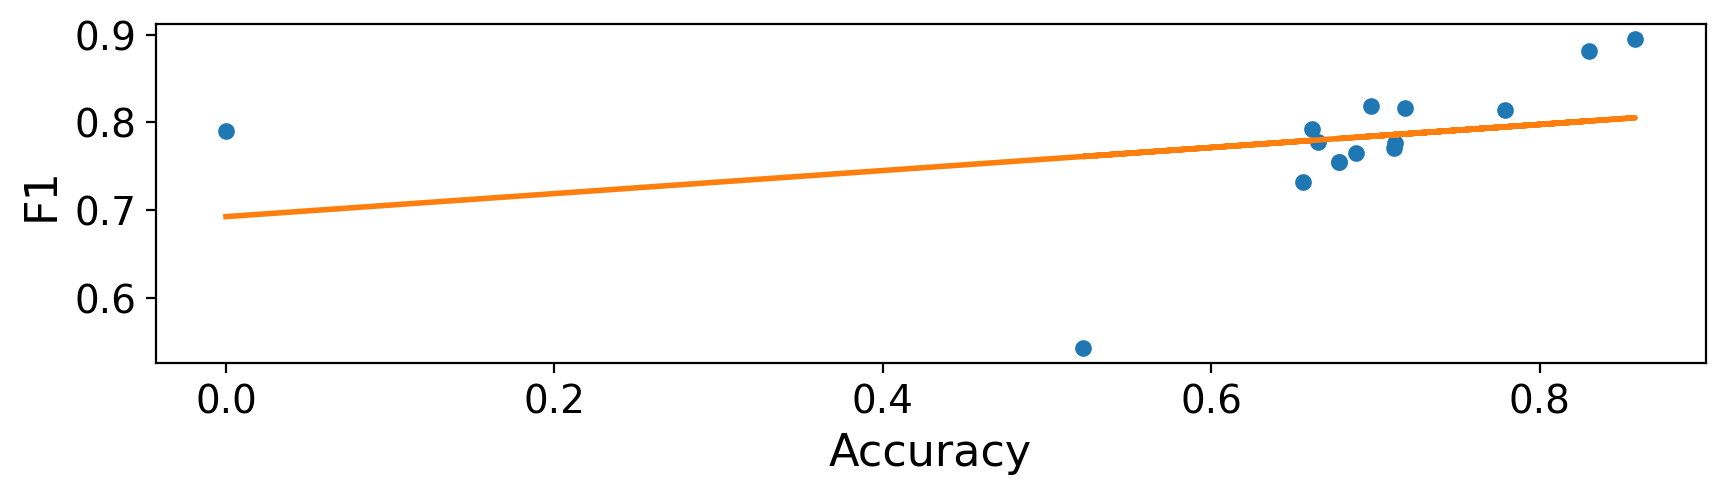

In [26]:
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt

# Sample data
x = np.arange(10)
y = 5 * x + 10
x = df['Accuracy'].to_numpy()
y = df['F1'].to_numpy()

# Fit with polyfit
b, m = polyfit(x, y, 1)

# plt.plot(x, y, '.')
# plt.plot(x, b + m * x, '-')
plt.plot(x, y, '.', markersize=10)
plt.plot(x, b + m * x, '-', linewidth=2)
plt.xlabel('Accuracy', fontsize=16)
plt.ylabel('F1', fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=14)

plt.show()

In [27]:
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.dpi"] = 300


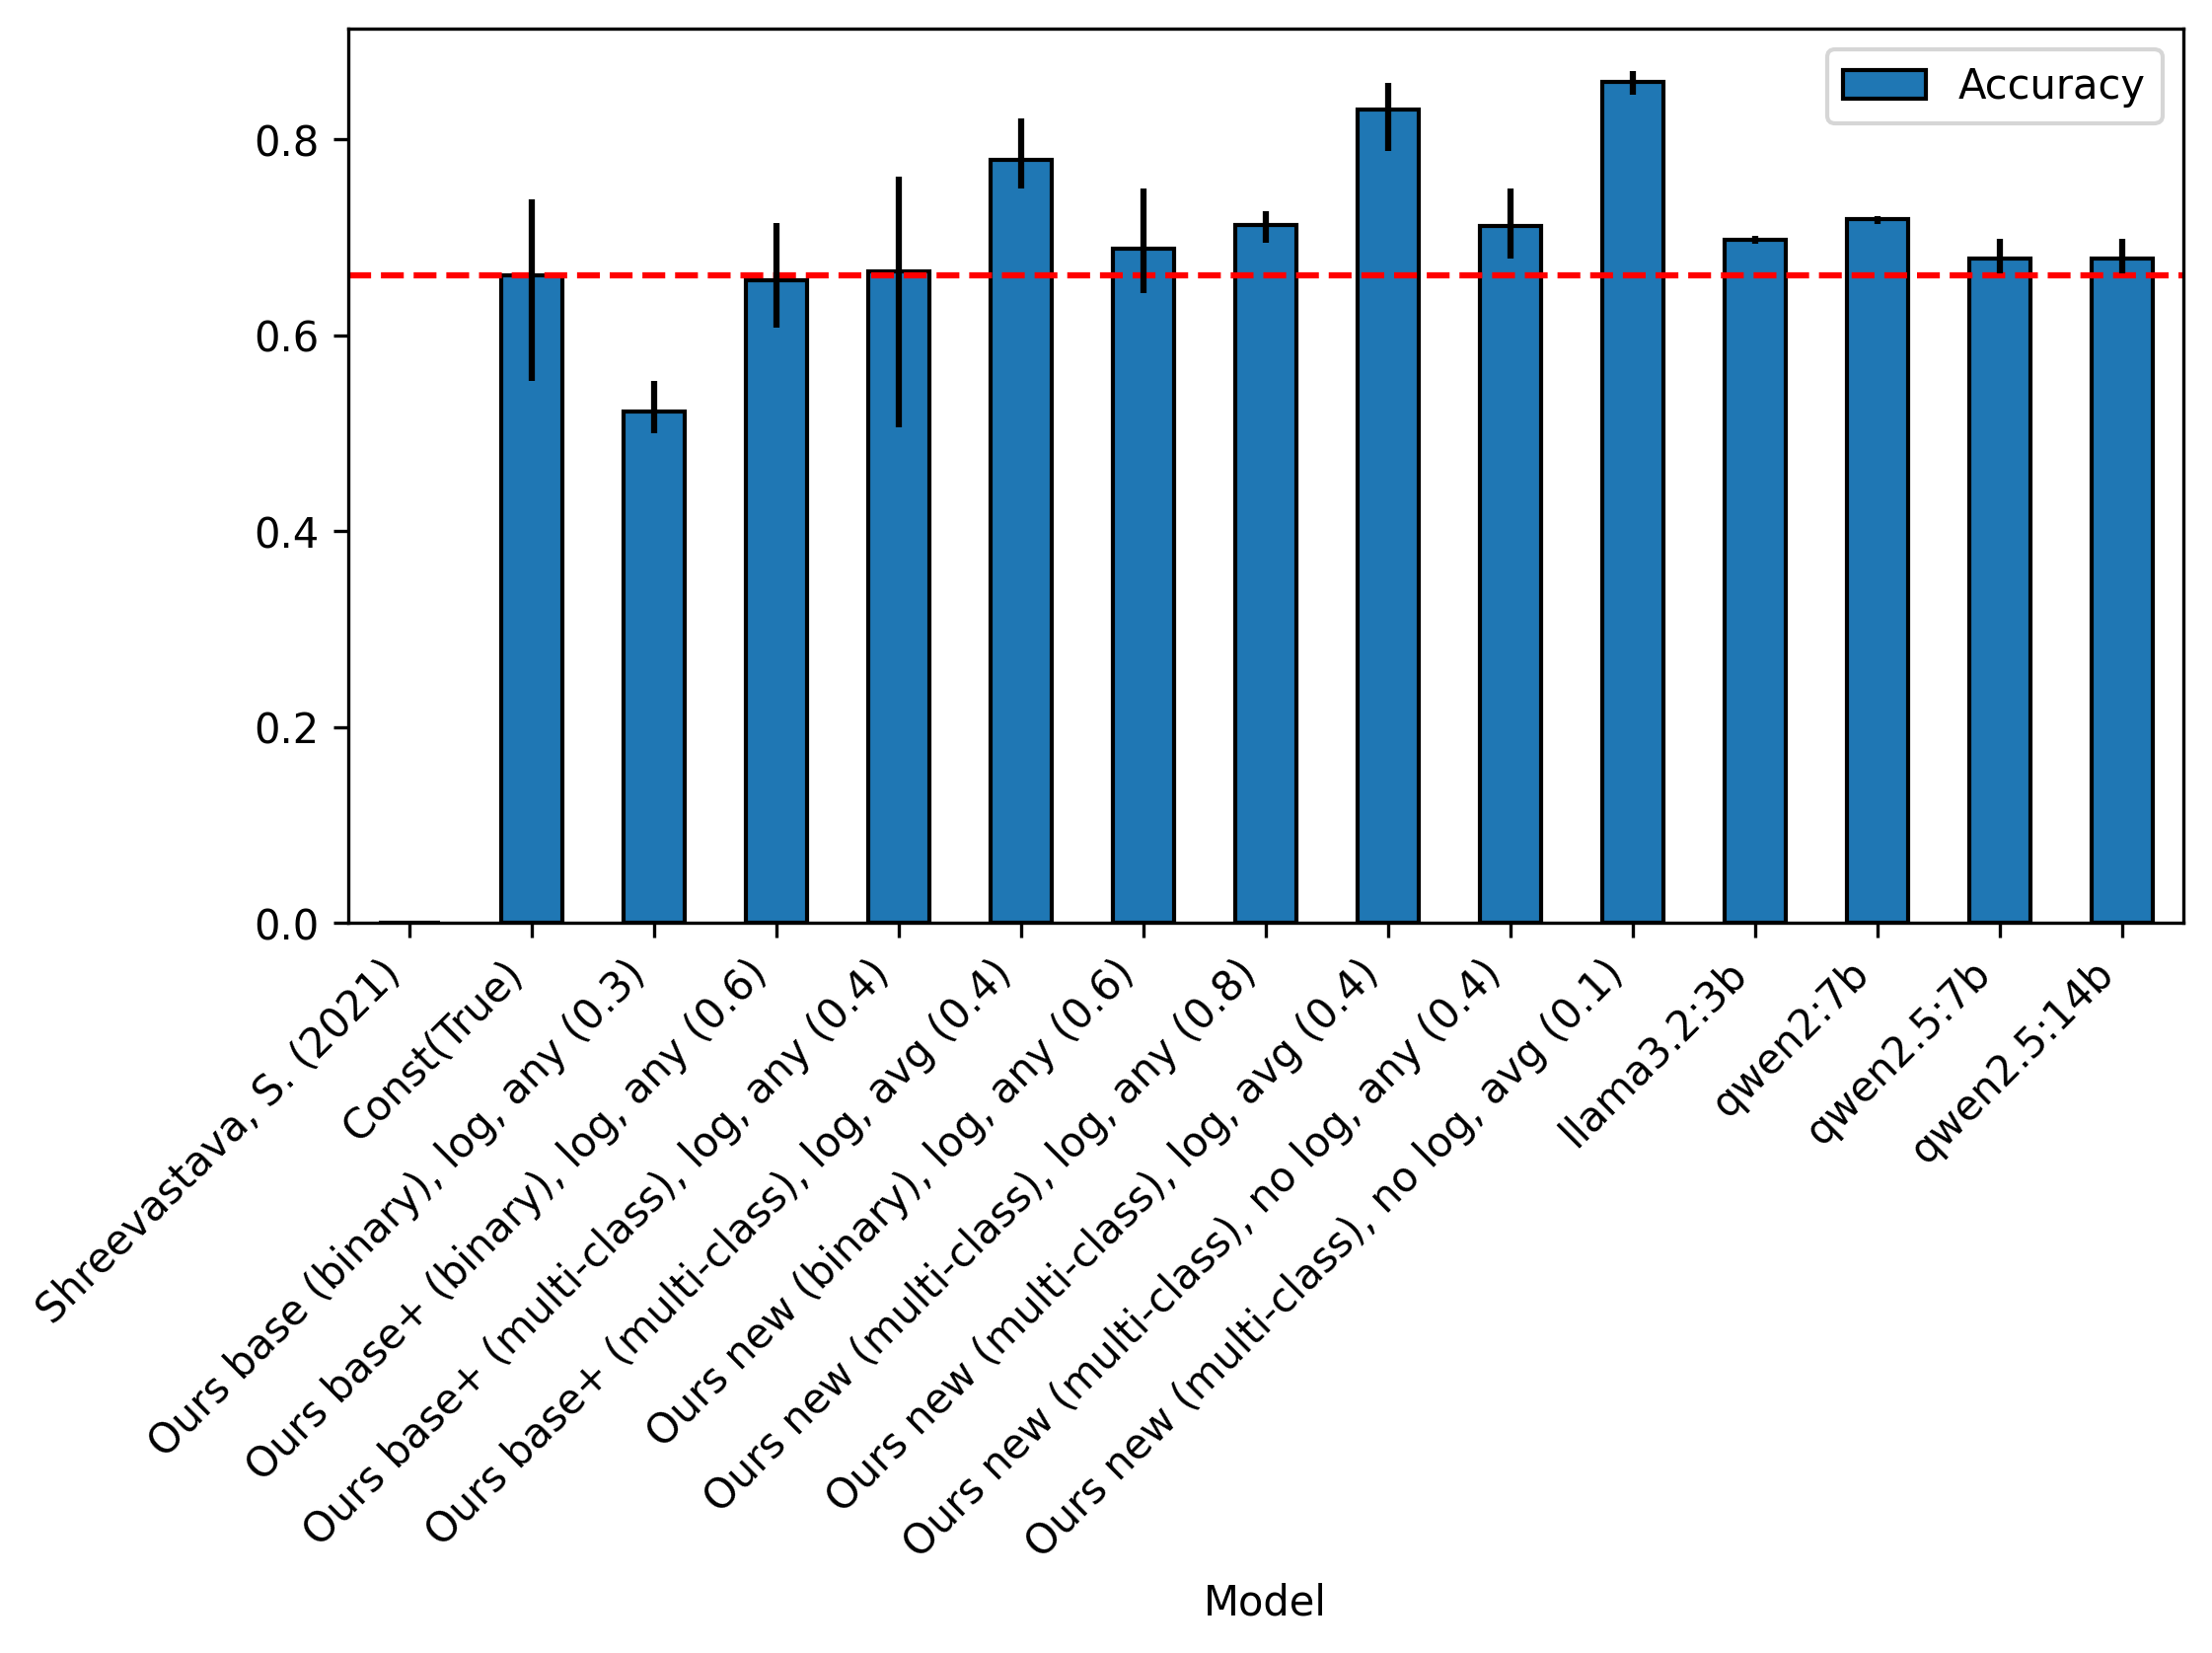

In [32]:
fig, ax = plt.subplots(figsize=(8, 4))
df.plot.bar(x='Model', y='Accuracy', ax=ax)
plt.axhline(y=0.661, color='r', linestyle='--', label='Baseline')
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = acc_error[h]['min']  # use h to get min from dict z
    max_y = acc_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line


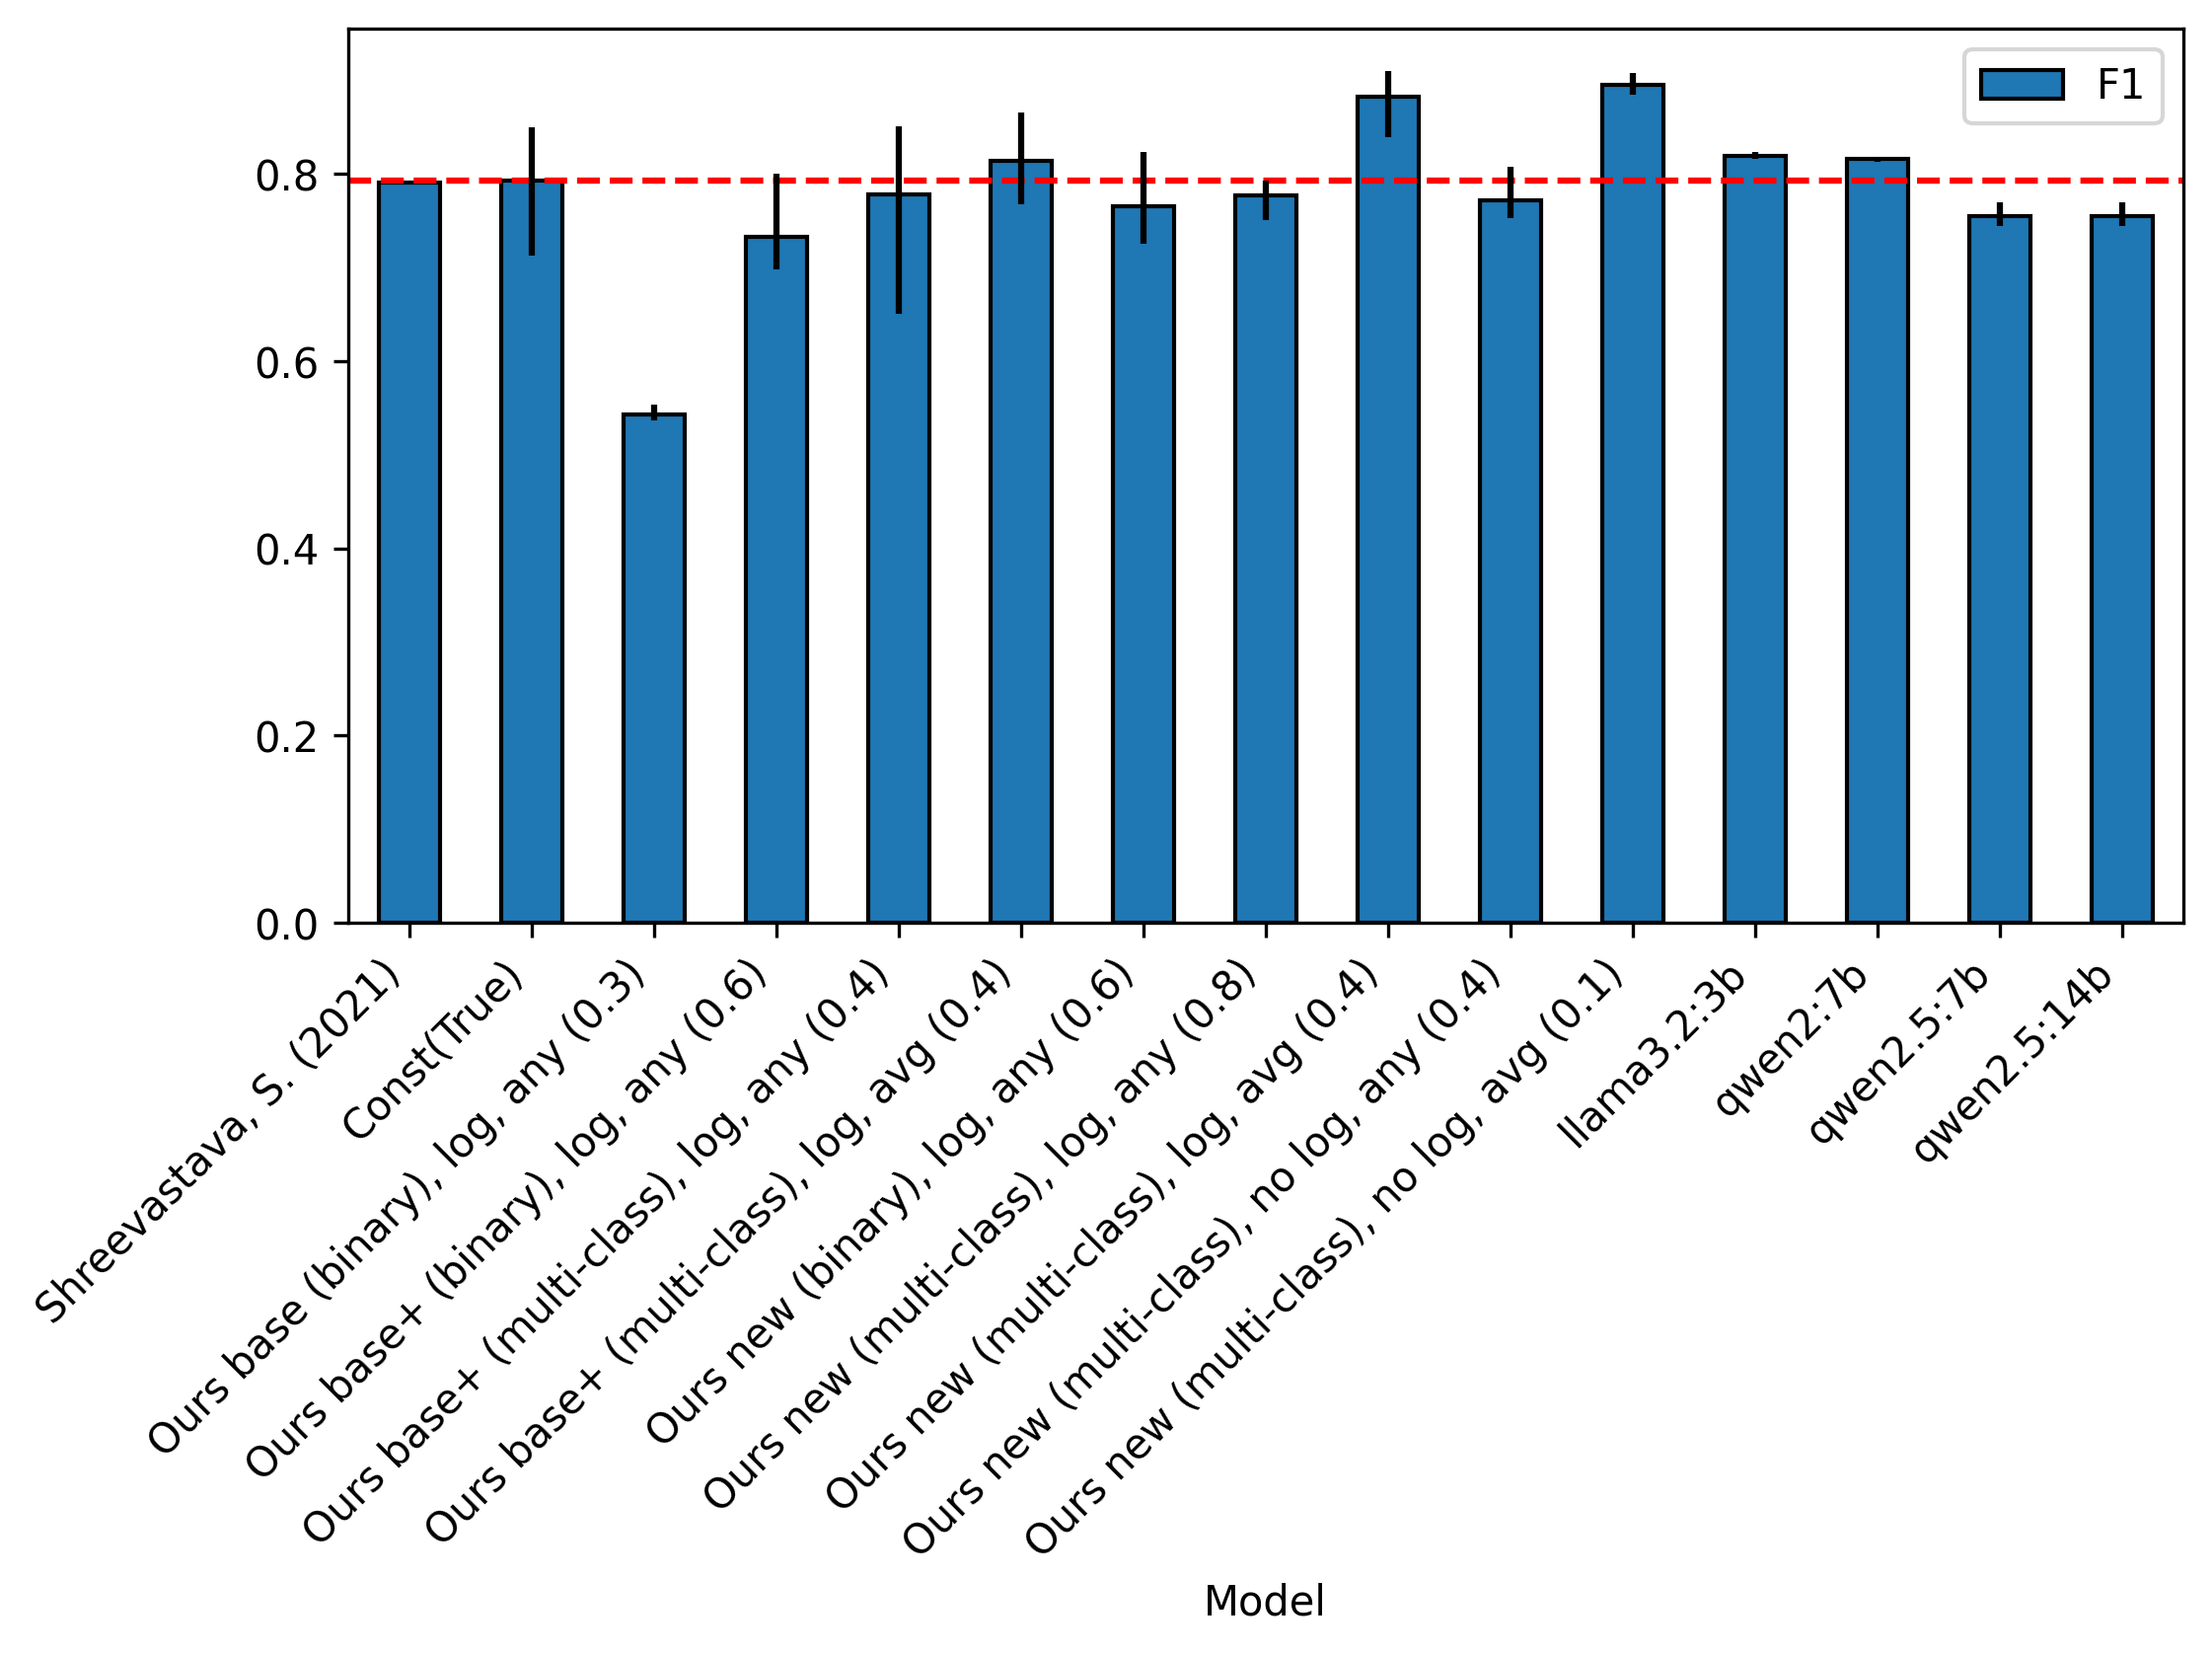

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))
df.plot.bar(x='Model', y='F1', ax=ax)
plt.axhline(y=0.793, color='r', linestyle='--', label='Baseline')
plt.xticks(rotation=45, ha='right')
for p in ax.patches:
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    min_y = f1_error[h]['min']  # use h to get min from dict z
    max_y = f1_error[h]['max']  # use h to get max from dict z
    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line

In [30]:
grand_t1 = dt.datetime.now()
grand_delta = grand_t1 - grand_t0
str(grand_delta)

'0:02:25.809899'